In [119]:
import xarray as xr
import netCDF4 as nc
import plotly
import chart_studio.plotly as py
import plotly.offline as py_off
import numpy as np
from scipy.io import netcdf
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'
import cartopy.feature as cf
import dash
import dash_core_components
import matplotlib
from __future__ import print_function
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.animation as anim
import cartopy
from IPython.display import HTML

In [120]:
file = '/data/bnb32/gfdl_data/held_suarez_default/run{}/atmos_monthly.nc'

In [121]:
file = '/data/bnb32/gfdl_data/variable_co2_grey_test_experiment/run{}/atmos_monthly.nc'

In [169]:
files = [file.format(str(i).zfill(4)) for i in range(1,120)]

In [144]:
def get_plotly_data(file,field,level=None):
    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc.Dataset(file)))
    df = ds[['lon','lat',f'{field}']].to_dataframe()

    if level is not None:
        levels = df.index.get_level_values('pfull')
        level = levels[np.argmin(np.abs(levels-level))]
        df = df[df.index.get_level_values('pfull') == level]
    
    step = 1.0
    to_bin = lambda x: np.floor(x / step) * step
    df["lat"] = df.index.get_level_values('lat').map(to_bin)
    df["lon"] = df.index.get_level_values('lon').map(to_bin)
    
    df.reset_index(drop=True, inplace=True)
    
    groups = df.groupby(["lat", "lon"])
    df_flat = df.drop_duplicates(subset=['lat', 'lon'])
    df = df_flat[np.isfinite(df_flat[f'{field}'])]
    df = df[(df.lat <= 90.0) & 
            (df.lat >= -90.0) & 
            (df.lon <= 360.0) & 
            (df.lon >= 0)]
    
    df['lon'] = df['lon'].apply(lambda x: x if x <= 180.0 else x-360.0)
    return df,ds
    

In [153]:
def get_data(files):
    data = xr.open_mfdataset(files,decode_times=False)
    return data

In [146]:
def get_animation(files,field,level=None):

# Load files
    data = get_data(files)
# Nomalise the longitude into [-180, 180)
#data['lon'] = data['lon'] - 360
    if level is not None:
    
        levels = np.array(data['pfull'].values)
        level = levels[np.argmin(np.abs(levels-level))]
# Select the variable & region of interest
        variable = data[field].sel(pfull = level)
    else:
        variable = data[field]

# Setup the initial plot
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
# Set up levels etc in this call
    #var = variable.mean(dim='time')
    image = variable.mean(dim='time').plot.imshow(ax=ax, transform=ccrs.PlateCarree(), 
                                                  interpolation='bilinear', 
                                                  animated=True, add_colorbar=False)

    cb = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.05, label=f'{data[field].long_name} ({data[field].units})')
    text = cb.ax.xaxis.label
    font = matplotlib.font_manager.FontProperties(size=16)
    text.set_font_properties(font)
    
# Set up static features - coastlines, political borders etc.
    ax.coastlines()

    def update(t):
    # Update the plot for a specific time
        #print(t)
        ax.set_title("time = %s"%t,fontsize=20)
        image.set_array(variable.sel(time=t))
        return image

# Run the animation, applying `update()` for each of the times in the variable
    animation = anim.FuncAnimation(fig, update, frames=variable.time.values, blit=False)

# Save to file or display on screen
#animation.save(f'{field}.mp4', fps=30)#, extra_args=['-vcodec', 'libx264'])
#plt.show()
    plt.close()
    return animation

In [168]:
def show_animation(files,field,level=None):
    animation = get_animation(files,field,None)
    return HTML(animation.to_html5_video())

In [148]:
def get_fig_data(file,field,level=None):

    df,ds = get_plotly_data(file,field,level=level)
    
    x_coords = []
    y_coords = []
    traces = []
    for coord_seq in cf.COASTLINE.geometries():
        x_coords.extend([k[0] for k in coord_seq.coords] + [np.nan])
        y_coords.extend([k[1] for k in coord_seq.coords] + [np.nan])  
    
    ## in your app callback for dash
    trace = go.Scatter(x = x_coords,
                       y = y_coords,
                       mode = 'lines',
                       line=go.Line(color="black"))
    traces.append(trace)
    
    contours = go.Contour(z=df[f'{field}'],
                          x=df['lon'],
                          y=df['lat'],
                          colorscale="RdBu",
                          zauto=False,  # custom contour levels
                          zmin=min(df[f'{field}']),      # first contour level
                          zmax=max(df[f'{field}'])        # last contour level  => colorscale is centered about 0
                          )
    data = go.Data([contours]+traces)
    
    title = u"{0} field ({1}) <br>".format(ds[f'{field}'].long_name,ds[f'{field}'].units)

    anno_text = "Data from ISCA simulation"
    #of \
    #<a href='http://www.esrl.noaa.gov/psd/data/composites/day/'>\
    #NOAA Earth System Research Laboratory</a>"

    axis_style = dict(zeroline=False,
                      showline=False,
                      showgrid=False,
                      ticks='',
                      showticklabels=False)

    layout = go.Layout(title=title,
                       showlegend=False,
                       hovermode="closest",        # highlight closest point on hover
                       xaxis=go.XAxis(axis_style,
                                      range=[min(df['lon']),
                                             max(df['lon'])]),  # restrict y-axis to range of lon
    
                       yaxis=go.YAxis(axis_style,
                                      range=[min(df['lat']),
                                             max(df['lat'])]),

                       annotations=go.Annotations([go.Annotation(text=anno_text,
                                                                 xref='paper',
                                                                 yref='paper',
                                                                 x=0,y=1,
                                                                 yanchor='bottom',
                                                                 showarrow=False)]),
                       autosize=False,
                       width=1000,
                       height=600)
    
    #layout = Layout(
    #paper_bgcolor='rgba(0,0,0,0)',
    #plot_bgcolor='rgba(0,0,0,0)'
    #)
    return data,layout
    

In [149]:
def plot_field(file,field,level=None):  
    data,layout = get_fig_data(file,field,level=level)
    fig = go.Figure(data=data,layout=layout)
    fig.show()    

In [30]:
plot_field(files[0],'vor',400)

/data/team/conda/envs/isca_post/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/data/team/conda/envs/isca_post/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/data/team/conda/envs/isca_post/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/data/team/conda/envs/isca_pos

In [31]:
plot_field(files[1],'vor',400)

In [32]:
frames = []
field = 'vor'
level = 400

axis_style = dict(zeroline=False,
                      showline=False,
                      showgrid=False,
                      ticks='',
                      showticklabels=False)

layout = go.Layout(title='',
                       showlegend=False,
                       hovermode="closest",        # highlight closest point on hover
                       xaxis=go.XAxis(axis_style,
                                      range=[min(get_data(files[0],field,level)[0]['lon']),
                                             max(get_data(files[0],field,level)[0]['lon'])]),  # restrict y-axis to range of lon
    
                       yaxis=go.YAxis(axis_style,
                                      range=[min(get_data(files[0],field,level)[0]['lat']),
                                             max(get_data(files[0],field,level)[0]['lat'])]),

                       annotations=go.Annotations([go.Annotation(text='',
                                                                 xref='paper',
                                                                 yref='paper',
                                                                 x=0,y=1,
                                                                 yanchor='bottom',
                                                                 showarrow=False)]),
                       autosize=False,
                       width=1000,
                       height=600,
         updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args = [None, {"frame": {"duration": 1000, 
                                                              "redraw": True},
                                                              "fromcurrent": True, 
                                                              "transition": {"duration": 0,"easing": "quadratic-in-out"}}])])])

for f in files:
    frames.append(go.Frame(data=get_fig_data(f,field,level)[0]))

fig = go.Figure(
    data=get_fig_data(files[0],field,level)[0],
    layout=layout,
    frames=frames
)

fig.show()

In [172]:
show_animation(files,'t_surf',None)

In [175]:
co2_path = '/data/bnb32/isca/exp/test_cases/variable_co2_concentration/input/'

In [218]:
import netCDF4 as nc
import numpy as np
import os

os.system(f'rm {co2_path}/co2.nc')
os.system(f'cp {co2_path}/co2_bkup.nc {co2_path}/co2.nc')
filename = f'{co2_path}/co2.nc'
ncfile = nc.Dataset(filename,'r+')
co2 = ncfile.variables['co2']
co2[:,:,:,:] = 2.0*co2[:,:,:,:]
ncfile.variables['co2'][:,:,:,:] = co2[:,:,:,:]
ncfile.close()

rm: cannot remove ‘/data/bnb32/isca/exp/test_cases/variable_co2_concentration/input//tmp.nc’: No such file or directory


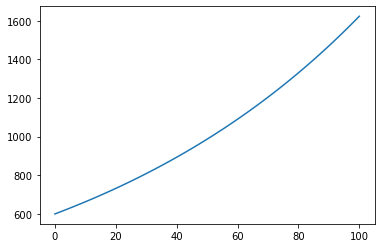

In [233]:
os.system(f'rm {co2_path}/tmp.nc')
os.system(f'cp {co2_path}/co2.nc {co2_path}/tmp.nc')
plt.plot(get_data(f'{co2_path}/tmp.nc')['co2'][:,0,0,0])